This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# A quick start to zonal statistics 

Zonal statistics can be used to compute e.g. the areal average precipitation over a catchment.

Here, we show a brief example using RADOLAN composite data from the German Weather Service (DWD).

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
from osgeo import osr

In [2]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

## Preparing the RADOLAN data

Preparing the radar composite data includes to
- read the data,
- geoference the data in native RADOLAN projection,
- reproject the data to UTM zone 32 projection.

In [3]:
# Read and preprocess the RADOLAN data
fpath = 'radolan/misc/raa01-sf_10000-1406100050-dwd---bin.gz'
f = wrl.util.get_wradlib_data_file(fpath)
ds = wrl.io.open_radolan_dataset(f)

In [4]:
# This is the native RADOLAN projection
# (polar stereographic projection)
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# This is our target projection (UTM Zone 32)
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# This is the source projection of the shape data
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)

0

In [5]:
# Get RADOLAN grid coordinates - center coordinates
x_rad, y_rad = np.meshgrid(ds.x, ds.y)
grid_xy_radolan = np.stack([x_rad, y_rad], axis=-1)
# Reproject the RADOLAN coordinates
xy = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_utm)
# assign as coordinates
ds = ds.assign_coords({"xc": (["y", "x"], xy[..., 0], dict(long_name="UTM Zone 32 Easting", units="m")),
                       "yc": (["y", "x"], xy[..., 1], dict(long_name="UTM Zone 32 Northing", units="m"))})

## Fix shapefile without projection information

As an example it is shown how to fix a shapefile with missing projection information.

In [6]:
from osgeo import ogr, osr, gdal
import os

# Shape Source Projection
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)

# This is our target projection (UTM Zone 32)
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

shpfile = wrl.util.get_wradlib_data_file('shapefiles/agger/agger_merge.shp')
dst_shpfile = shpfile[:-4] + "_gk2.shp"

def transform_shapefile(src, dst, dst_srs, dst_driver='ESRI Shapefile', src_srs=None):
    # remove destination file, if exists
    driver = ogr.GetDriverByName(dst_driver)
    if os.path.exists(dst_shpfile):
        driver.DeleteDataSource(dst_shpfile)
    
    # create the output layer
    dst_ds = driver.CreateDataSource(dst)
    dst_lyr = dst_ds.CreateLayer("", dst_srs, geom_type=ogr.wkbPolygon)
    
    # get the input layer
    src_ds = gdal.OpenEx(src)
    src_lyr = src_ds.GetLayer()
    
    # transform - reproject
    wrl.georef.ogr_reproject_layer(src_lyr, dst_lyr, dst_srs, src_srs=src_srs)

    # unlock files
    dst_ds = None
    src_ds = None

transform_shapefile(shpfile, dst_shpfile, proj_gk2, src_srs=proj_gk2)

## Import catchment boundaries from ESRI shapefile

### Create trg VectorSource

This shows how to load data in a specific projection and project it on the fly to another projection. Here gk2 -> utm32.

In [7]:
shpfile = wrl.util.get_wradlib_data_file(
    'shapefiles/agger/agger_merge_gk2.shp')
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg")
print(f"Found {len(trg)} sub-catchments in shapefile.")

Found 13 sub-catchments in shapefile.


In [8]:
# check projection
print(trg.crs)

PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]


## Clip subgrid from RADOLAN grid 

This is just to speed up the computation (so we don't have to deal with the full grid).

In [9]:
bbox = trg.extent
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
print(bbox)

{'left': 365059.5928799211, 'right': 419830.11388741195, 'bottom': 5624046.706676126, 'top': 5668055.540990271}


In [10]:
ds_clip = ds.where((((ds.yc > bbox['bottom']) & (ds.yc < bbox['top'])) &
                    ((ds.xc > bbox['left']) & (ds.xc < bbox['right']))), drop=True)
display(ds_clip)

<xarray.Dataset>
Dimensions:  (y: 48, x: 58, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-10T00:50:00
  * y        (y) float64 -4.234e+03 -4.233e+03 ... -4.188e+03 -4.187e+03
  * x        (x) float64 -214.5 -213.5 -212.5 -211.5 ... -159.5 -158.5 -157.5
    xc       (y, x) float64 3.66e+05 3.669e+05 3.679e+05 ... 4.184e+05 4.193e+05
    yc       (y, x) float64 5.623e+06 5.623e+06 ... 5.669e+06 5.669e+06
Data variables:
    SF       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    radarid:         10000
    radolanversion:  2.13.1
    radarlocations:  ['asw', 'boo', 'emd', 'han', 'umd', 'pro', 'ess', 'drs',...
    radardays:       ['asw 10', 'boo 24', 'drs 24', 'emd 24', 'ess 24', 'fbg ...

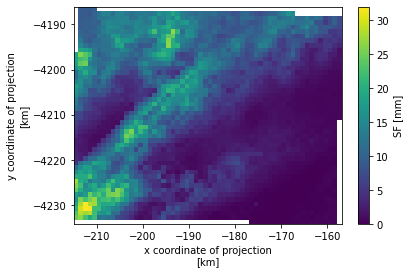

In [11]:
ds_clip.SF.plot()

## Compute the average precipitation for each catchment

To compute the zonal average, we have to understand the the grid cells as *polygons* defined by a set of *vertices*.

In [12]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grid_x, grid_y = np.meshgrid(ds_clip.x + 0.5, ds_clip.y + 0.5)
grdverts = wrl.zonalstats.grid_centers_to_vertices(grid_x,
                                                   grid_y, 
                                                   1., 1.)

### Create src VectorSource

This shows how to load data via numpy arrays in a given source projection and project it on the fly to a needed target projection

In [13]:
src = wrl.io.VectorSource(grdverts, srs=proj_utm, name="src", projection_source=proj_stereo)

Now we create the `ZonalDataPoly` class instance providing `src`  and `trg` VectorSources. Based on the overlap of these polygons with the catchment area, we can then compute a *weighted average*. 

In [14]:
# This object collects our source and target data
#   and computes the intersections
zd = wrl.zonalstats.ZonalDataPoly(src, trg, srs=proj_utm)
#zd = wrl.zonalstats.ZonalDataPoly(grdverts, shpfile, srs=proj_utm)

# This object can actually compute the statistics
obj = wrl.zonalstats.ZonalStatsPoly(zd)

# We just call this object with any set of radar data
avg = obj.mean(ds_clip.SF.values.ravel())


## Plot results in map using matplotlib

We now plot the data using matplotlib accessors of `geopandas` (vector) and `xarray` (raster).

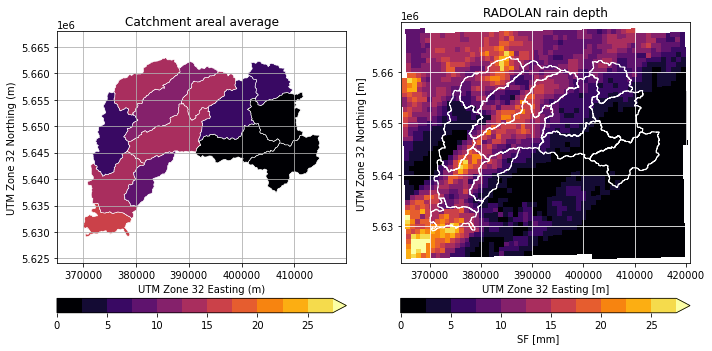

In [15]:
from matplotlib.colors import from_levels_and_colors

# Create discrete colormap
levels=np.arange(0,30,2.5)
colors = pl.cm.inferno(np.linspace(0, 1, len(levels)))
mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

fig = pl.figure(figsize=(10, 10))

# Average rainfall sum
ax = fig.add_subplot(121, aspect="equal")
obj.zdata.trg.geo.plot(column="mean", ax=ax, 
                       cmap=mycmap, norm=mynorm, 
                       edgecolor="white", lw=0.5,
                       legend=True, legend_kwds=dict(orientation="horizontal", pad=0.05))
pl.xlabel("UTM Zone 32 Easting (m)")
pl.ylabel("UTM Zone 32 Northing (m)")
pl.title("Catchment areal average")
bbox = obj.zdata.trg.extent
pl.xlim(bbox[0] - 5000, bbox[1] + 5000)
pl.ylim(bbox[2] - 5000, bbox[3] + 5000)
pl.grid()

# Original radar data
ax = fig.add_subplot(122, aspect="equal")
pm = ds_clip.SF.plot(x="xc", y="yc", cmap=mycmap, norm=mynorm, ax=ax, 
                   cbar_kwargs=dict(orientation="horizontal", pad=0.05))
obj.zdata.trg.geo.plot(ax=ax, facecolor="None", edgecolor="white")
pl.title("RADOLAN rain depth")
pl.grid(color="white")
pl.tight_layout()

## Plot results in interactive map using geopandas

Interactive mapmaking is easy using `geopandas`:

In [16]:
fmap = obj.zdata.trg.geo.explore(column="mean")
fmap

## Save time by reading the weights from a file

The computational expensive part is the computation of intersections and weights. You only need to do it *once*.

You can dump the results on disk and read them from there when required. Let's do a little benchmark:

In [17]:
import datetime as dt

# dump to file
zd.dump_vector('test_zonal_poly_cart')

t1 = dt.datetime.now()
# Create instance of type ZonalStatsPoly from zonal data file
obj = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly_cart')
t2 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from scratch
src = wrl.io.VectorSource(grdverts, srs=proj_utm, name="src", projection_source=proj_stereo)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg")
zd = wrl.zonalstats.ZonalDataPoly(src, trg)
obj = wrl.zonalstats.ZonalStatsPoly(zd)
t3 = dt.datetime.now()

# Calling the object
avg = obj.mean(ds_clip.SF.values.ravel())
t4 = dt.datetime.now()

print("\nCreate object from file: %f seconds" % (t2 - t1).total_seconds())
print("Create object from sratch: %f seconds" % (t3 - t2).total_seconds())
print("Compute stats: %f seconds" % (t4 - t3).total_seconds())


Create object from file: 0.095461 seconds
Create object from sratch: 0.561187 seconds
Compute stats: 0.001924 seconds


### Calculate Variance and Plot Result

In [18]:
var = obj.var(ds_clip.SF.values.ravel())

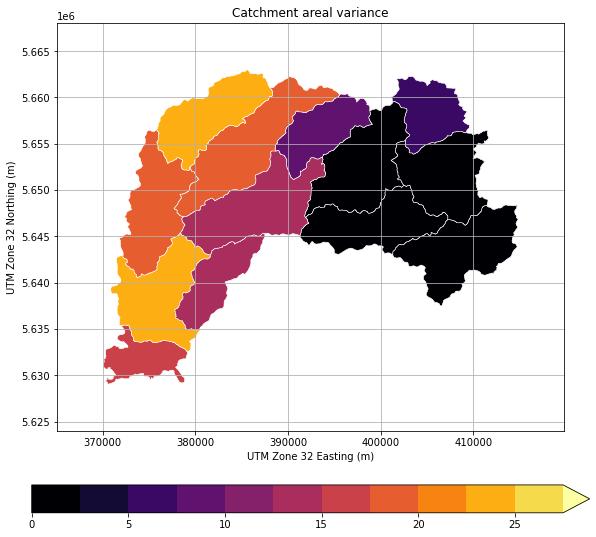

In [19]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
obj.zdata.trg.geo.plot(column="var", ax=ax, 
                       cmap=mycmap, norm=mynorm, 
                       edgecolor="white", lw=0.5,
                       legend=True, legend_kwds=dict(orientation="horizontal", pad=0.1))
pl.xlabel("UTM Zone 32 Easting (m)")
pl.ylabel("UTM Zone 32 Northing (m)")
pl.title("Catchment areal variance")
bbox = obj.zdata.trg.extent
pl.xlim(bbox[0] - 5000, bbox[1] + 5000)
pl.ylim(bbox[2] - 5000, bbox[3] + 5000)
pl.grid()